In [1]:
import sys
import os

# Get the parent directory of the "notebook" folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to the Python path
sys.path.append(project_root)

In [2]:
from strategies.ANN_returns import ANNReturnStrategy
from strategies.ANN_prices import ANNPriceStrategy
from utils.backtest import Backtest
from utils.data_handler import DataHandler
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data_handler = DataHandler(ticker='MSFT', start_date='2020-01-01', end_date='2024-01-01')
data = data_handler.fetch_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### Technicals in a simple NN to do a single-period prediction 

Chapter 2: Calculation of technical indicators. Focus on S&P 500 stocks. Use technicals in a simple NN to do single-period prediction. Examine price prediction versus return prediction.

c:\Users\lisam\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


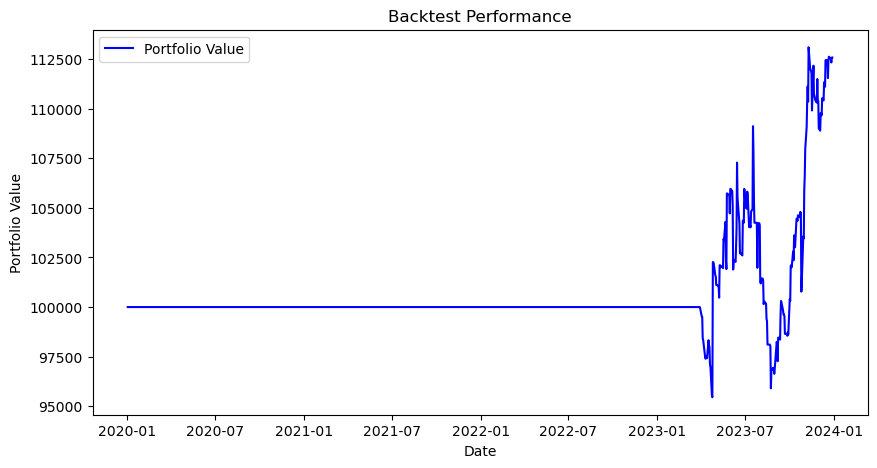

{'Final Value': 112580.22299923761, 'Return': 0.125802229992376, 'Sharpe Ratio': 0.419134158378075, 'Max Drawdown': -0.12108666619629227}


In [4]:
# Prices
price_strategy = ANNPriceStrategy()
backtest_prices = Backtest(data, price_strategy)
results_prices = backtest_prices.run()
print(results_prices)

c:\Users\lisam\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


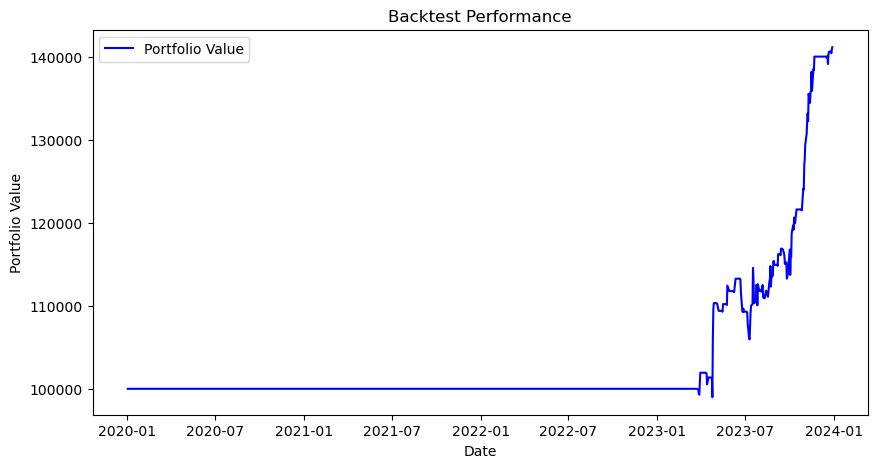

{'Final Value': 141142.2785848697, 'Return': 0.41142278584869696, 'Sharpe Ratio': 1.2112635070320397, 'Max Drawdown': -0.06458873992929826}


In [5]:
# Returns
returns_strategy = ANNReturnStrategy()
backtest_returns = Backtest(data, returns_strategy)
results_returns = backtest_returns.run()
print(results_returns)

#### Price prediction vs Return prediction

In [9]:
import numpy as np

c:\Users\lisam\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


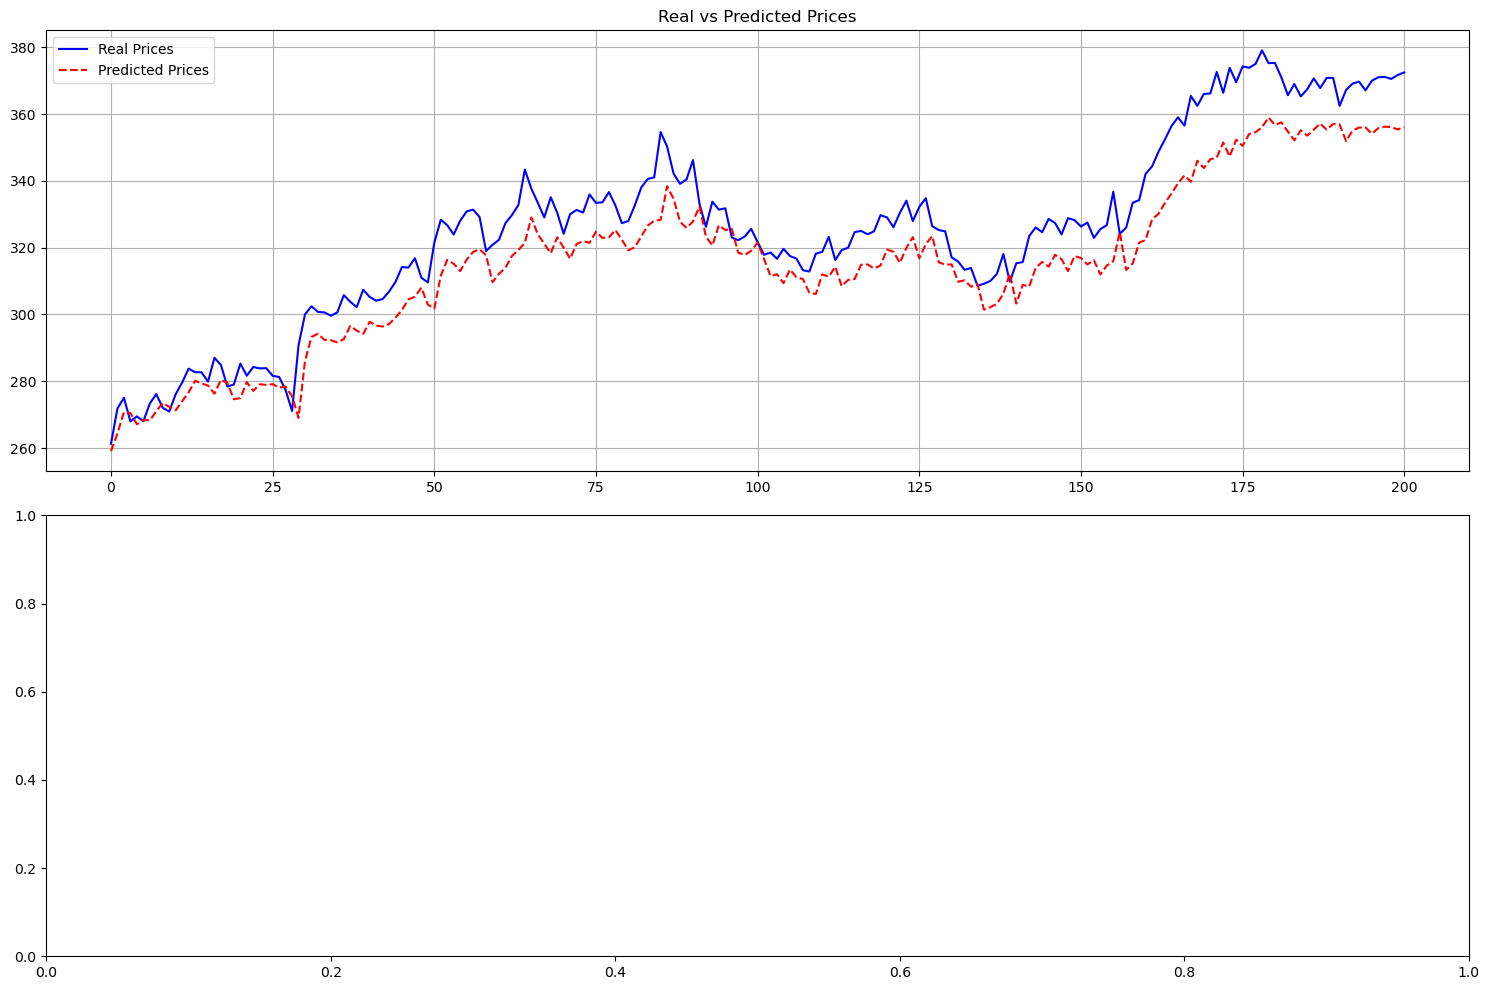


Price Prediction:
MSE: 143.24
R²: 0.82


In [11]:
# 1. Price Strategy
price_strategy.generate_signals(data)  # Train the model

# Get price predictions
test_size = int(len(data) * 0.2)
real_prices = data['Close'].iloc[-test_size:].values
predicted_prices = price_strategy.scaler_y.inverse_transform(
    price_strategy.model.predict(price_strategy.scaler_X.transform(
        price_strategy.compute_indicators(data)[['SMA20', 'SMA50', 'Price_SMA20', 'RSI', 'MACD',
                                               'BB_upper', 'BB_lower', 'Price_BB_up']].iloc[-test_size:]
    ))
)


# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Prices
ax1.plot(real_prices, label='Real Prices', color='blue')
ax1.plot(predicted_prices, label='Predicted Prices', color='red', linestyle='--')
ax1.set_title('Real vs Predicted Prices')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()

# Performance Metrics
print("\nPrice Prediction:")
print(f"MSE: {mean_squared_error(real_prices, predicted_prices):.2f}")
print(f"R²: {r2_score(real_prices, predicted_prices):.2f}")


c:\Users\lisam\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


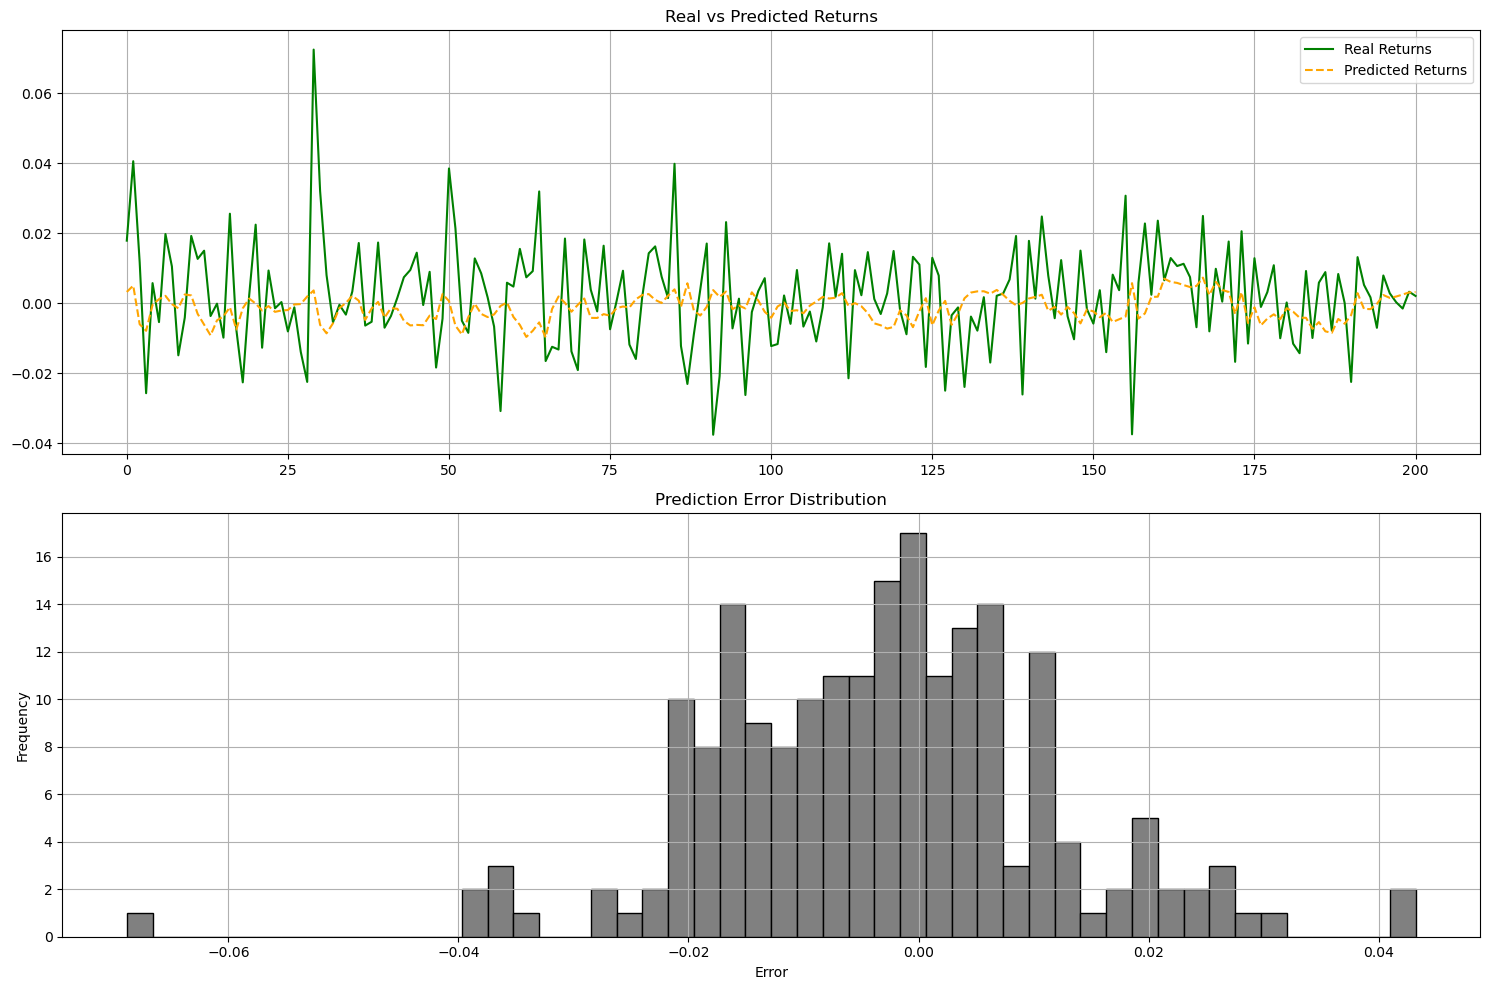


Return Prediction:
MSE: 0.000232
R²: -0.0719


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# 1. Return Strategy
returns_strategy.generate_signals(data)  # Entraîne le modèle

# Taille du test
test_size = int(len(data) * 0.2)

# Indicateurs et features utilisés pour la prédiction
features = ['RSI', 'MACD', 'BB_width', 'Price_EMA20']
indicators_df = returns_strategy.compute_indicators(data)

# Données d'entrée X (standardisées)
X_test_scaled = returns_strategy.scaler_X.transform(indicators_df[features].iloc[-test_size:])

# Prédiction des returns
predicted_returns_scaled = returns_strategy.model.predict(X_test_scaled)
predicted_returns = returns_strategy.scaler_y.inverse_transform(predicted_returns_scaled).flatten()

# Rendements réels
real_returns = indicators_df['Return_Next'].iloc[-test_size:].values

# Nettoyage des données
valid_mask = ~(np.isnan(real_returns) | np.isnan(predicted_returns))
real_returns = real_returns[valid_mask]
predicted_returns = predicted_returns[valid_mask]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Courbe des rendements
ax1.plot(real_returns, label='Real Returns', color='green')
ax1.plot(predicted_returns, label='Predicted Returns', color='orange', linestyle='--')
ax1.set_title('Real vs Predicted Returns')
ax1.legend()
ax1.grid(True)

# Histogramme des erreurs et test de normalité
errors = predicted_returns - real_returns
stat, p_value = stats.normaltest(errors)
ax2.hist(errors, bins=50, density=True, color='gray', edgecolor='black', alpha=0.7)
# Ajouter une courbe de distribution normale
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
mean, std = stats.norm.fit(errors)
pdf = stats.norm.pdf(x, mean, std)
ax2.plot(x, pdf, 'r-', lw=2, label='Normal fit')
ax2.set_title(f'Prediction Error Distribution\Normality test p-value: {p_value:.4f}')
ax2.set_xlabel('Error')
ax2.set_ylabel('Frequency')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Performance Metrics
print("\nReturn Prediction:")
print(f"MSE: {mean_squared_error(real_returns, predicted_returns):.6f}")
print(f"R²: {r2_score(real_returns, predicted_returns):.4f}")
print(f"Mean Error: {np.mean(errors):.6f}")
print(f"Std Error: {np.std(errors):.6f}")
print(f"Mean Absolute Error: {np.mean(np.abs(errors)):.6f}")
print("\nCorrelation Analysis:")
correlation = np.corrcoef(real_returns, predicted_returns)[0, 1]
print(f"Correlation coefficient: {correlation:.4f}")
print(f"Spearman rank correlation: {stats.spearmanr(real_returns, predicted_returns)[0]:.4f}")
